In [ ]:
# Start writing code here...
print("Hello World!")

Hello World!


1. Basic network description of your data (what type of network it is, what does it represent, is it real or synthetically generated, etc). In practice, the result of project phase #1 (finding data).

The network represents the "darkweb". The nodes represent websites and the edges represents hyperlinks. 

2. Basic network statistics of your data (number of nodes, edges, clustering, degree distribution, etc). In practice, the result of project phase #2 (exploratory data analysis).

Number of nodes: 7178, edges: 25.104, clustering: ?, degree dist:


3. A clear statement of your research question, the result of project phase #3.
The analysis, results, and interpretation that allow you to answer your research question, the result of project phase #4.

In [ ]:
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


In [ ]:
edge_df = pd.read_csv("cleaned_data/darkweb_edgelist.csv", delimiter=",", header=0)
node_df = pd.read_csv("cleaned_data/darkweb_nodelist.csv", delimiter=",", header=0)

In [ ]:
edge_df.head()

,Source,Target,Weight
0,visitorfi5kl7q7i,uisspxbl7ipc5bet,1
1,visitorfi5kl7q7i,xidp5a5k3rlxr5r3,1
2,visitorfi5kl7q7i,7uvijlsswycvih2p,1
3,visitorfi5kl7q7i,4oy7nsv57l3ragqz,1
4,visitorfi5kl7q7i,prometh5th5t5rfd,1


In [ ]:
node_df.head()

,Id,Degree
0,visitorfi5kl7q7i,4385
1,uisspxbl7ipc5bet,3
2,directoryvi6plzm,3
3,telnetg42y5crrb7,4
4,gl75awtvsmp2ofe6,2


In [ ]:
G = nx.from_pandas_edgelist(edge_df, source="Source", target="Target", edge_attr="Weight", create_using=nx.DiGraph())

In [ ]:
%%script echo skipping
fig, ax = plt.subplots(figsize=(15,10))

pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_nodes(G, pos, node_size=1)
#nx.draw_networkx_edges(G, pos)
plt.show()

skipping


In [ ]:
# global clustering coefficient
nx.transitivity(G)

0.0009640276195779557

https://graph-tool.skewed.de/static/doc/clustering.html?highlight=clustering


In [ ]:
# average clustering coefficient
nx.average_clustering(G)

nx.transitivity(G) # the fraction of all possible triangles present in G.
#nx.triangles(G,0) doesn't work or directed :(

#graph_tool.clustering.local_clustering(G, weight=None, prop=None, undirected=False)

0.0009640276195779557

In [ ]:
nx.number_strongly_connected_components(G)

6820

In [ ]:
nx.number_weakly_connected_components(G)

1

## 2

Basic network statistics of your data (number of nodes, edges, clustering, degree distribution, etc). In practice, the result of project phase #2 (exploratory data analysis).

## Degree Distribution

A degree distribution is a degree scatter plot, the degree on the x-axis and the number of nodes on the y-axis.

Commonly, one would normalise the y-axis by dividing its values by the number of nodes in the network, and the y-axis is the probability if a node to have a degree equal to k.

In [ ]:
# Add a column to the dataframe with the node's degree

#degree_dict = G.degree()
#result = []
#for value in degree_dict:
#    result.append(value[1])
#node_df["Degree"] = result
num_degrees = Counter(node_df["Degree"]) 

degrees = num_degrees.keys()
counts = num_degrees.values()

pw = pd.DataFrame()
pw["k"] = degrees
pw["count"] = counts
pw

,k,count
0,4385,1
1,3,1614
2,4,1033
3,2,1667
4,19,11
...,...,...
99,2810,1
100,152,1
101,31,1
102,482,1


<AxesSubplot:xlabel='k', ylabel='count'>

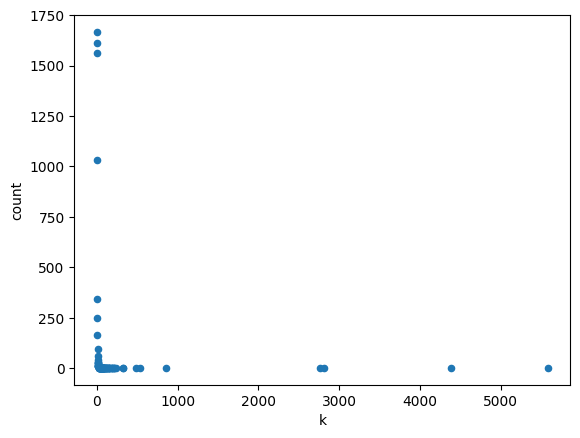

In [ ]:
# plot the degrees against the number of nodes 


prob_degrees = []
#for node in 

pw.plot(x = "k", y = "count", kind = "scatter")

<AxesSubplot:xlabel='k', ylabel='count'>

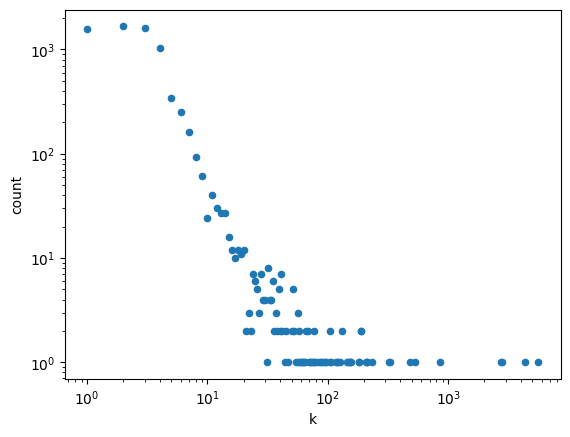

In [ ]:
pw.plot(x = "k", y = "count", kind = "scatter", loglog= True)

### The CCDF of the dergee distribution (the complement of a cumulative distribution function:)
The most common way to visualize degrees is by drawing cumulative distributions (CDF)

To make the CCDF we need to know how many nodes have degree equal to or higher
than a specific value. So we sort the dataframe in descending degree order, so
that the pandas cumsum function will calculate that for us. Then we normalize by
the total degree sum, so that the count becomes a probability. We then sort in
ascending degree value, to respect the convention.

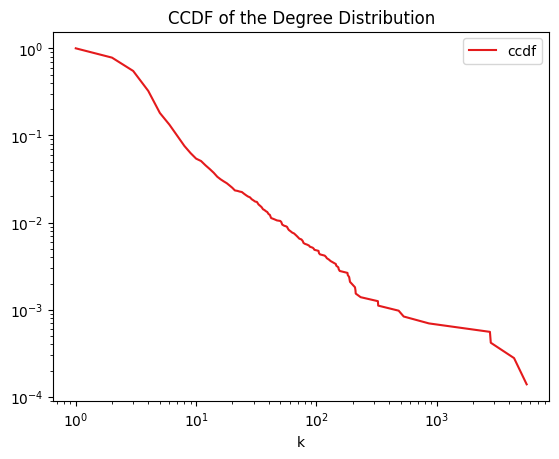

In [ ]:

ccdf = pw.sort_values(by = "k", ascending = False)
ccdf["cumsum"] = ccdf["count"].cumsum()
ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
ccdf = ccdf[["k", "ccdf"]].sort_values(by = "k")



# Plot as usual and save it for later, since it's very pretty.
ccdf.plot(kind = "line", x = "k", y = "ccdf", color = "#e41a1c", loglog = True)
plt.title("CCDF of the Degree Distribution")
plt.savefig("degree_distribution_ccdf.png")

### Check for Power-law

Many networks have a power law degree distribution, but rarely this is a pure power law: it is often shifted or truncated. Fitting a power law and finding the correct exponent is tricky and you should not do it using a linear regression.

$p(k) \sim k^{-\alpha}$

In [ ]:
from scipy.stats import linregress
import numpy as np
import powerlaw as pl

# We take the logarithm in base 10 of both degree and CCDF. Then we simply do a linear regression. 
# The slope is
# the exponent. The intercept needs to be the power of 10, to undo the logarithm operation. 
# Look at that r-squared!
logcdf = np.log10(ccdf[["k", "ccdf"]])
slope, log10intercept, r_value, p_value, std_err = linregress(logcdf["k"], logcdf["ccdf"])
print("CCDF Fit: %1.4f x ^ %1.4f (R2 = %1.4f, p = %1.4f)" % (10 ** log10intercept, slope, r_value ** 2, p_value))

CCDF Fit: 0.6240 x ^ -1.0403 (R2 = 0.9656, p = 0.0000)


In [ ]:
# With the powerlaw package, fitting the CCDf is simple. It will store results in 
# the .power_law property. To get the actual k_min, we need to find the degree value 
# corresponding to the probability in .power_law.xmin:
# pandas makes it easy. This is definitely a shifted power law. 
# (Kappa contains the intercept information)
results = pl.Fit(ccdf["ccdf"])
k_min = ccdf[ccdf["ccdf"] == results.power_law.xmin]["k"]
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

Powerlaw CCDF Fit: 10.0883 x ^ -1.9079 (k_min = 41)
Calculating best minimal value for power law fit
/opt/conda/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


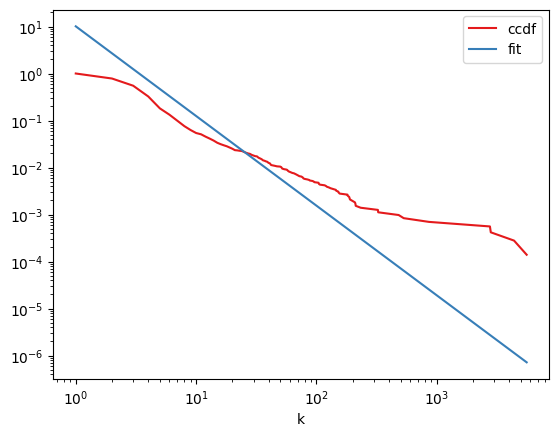

In [ ]:
# Let's plot the best fit.
ccdf["fit"] = (10 ** results.power_law.Kappa) * (ccdf["k"] ** -results.power_law.alpha)
ax = plt.gca()
ccdf.plot(kind = "line", x = "k", y = "ccdf", color = "#e41a1c", loglog = True, ax = ax)
ccdf.plot(kind = "line", x = "k", y = "fit", color = "#377eb8", loglog = True, ax = ax)
plt.savefig("ccdf_fit.png")

In [ ]:
node_df

,Id,Degree
0,visitorfi5kl7q7i,4385
1,uisspxbl7ipc5bet,3
2,directoryvi6plzm,3
3,telnetg42y5crrb7,4
4,gl75awtvsmp2ofe6,2
...,...,...
7173,4co7hns6t7qt22ix,1
7174,mwprbruk4sc5t4li,2
7175,vysoofjtouvo2bl3,1
7176,lxvfo33z43yd6piu,1


In [ ]:
edge_df

,Source,Target,Weight
0,visitorfi5kl7q7i,uisspxbl7ipc5bet,1
1,visitorfi5kl7q7i,xidp5a5k3rlxr5r3,1
2,visitorfi5kl7q7i,7uvijlsswycvih2p,1
3,visitorfi5kl7q7i,4oy7nsv57l3ragqz,1
4,visitorfi5kl7q7i,prometh5th5t5rfd,1
...,...,...,...
25099,jzsm6raa2iw3hkue,tt3j2x4k5ycaa5zt,1
25100,3prjgaibgjpkkknu,tt3j2x4k5ycaa5zt,3
25101,grams5ieqi6zi3n7,toradsc6vvmtugty,1
25102,ijb7rxextmnhkd76,torvps7kzis5ujfz,3


### Graph Density
The density of a graph is the ratio of observed edges to the number of possible edges for a network.
Our network/graph is directed, so the formula we will use to calculate this is:
$d = \frac{m}{n (n - 1)}$. We will calculate both ways, by using the formula, and by using the Network X function for density `density()`.
The density for a graph would be 0 if there are none edges, and the density for a graph would be 1 if the graph is complete. Meaning that if all the nodes was multiplied by itself, minus 1 node, then the graph would be complete and have a density of 1.

In [ ]:
# Graph density with a formula.

n = 7178
m = 25104

# This is the density formula for a directed graph:
d = m / (n * (n - 1))
print(f'This is the density of a directed graph, calculated using the formula: {d}')

This is the density of a directed graph, calculated using the formula: 0.00048730012862285344


In [ ]:
# Graph density with NetworkX.

def number_of_nodes(G):
# This will return the number of nodes
    return G.number_of_nodes()

def number_of_edges(G):
# This will return the number of edges
    return G.number_of_edges()

def density(G):
# We define the number of nodes and edges of the graph
    n = number_of_nodes(G)
    m = number_of_edges(G)
# We make an if-statement: if edge is 0 or node is less than or equal to 1, we return the number 0, meaning there is no edge.
    if m == 0 or n <= 1:
        return 0
# We then calculate the density, using the formula for a directed graph.
    d = m / (n * (n - 1))

'''
We choose to comment this whole part out, since it is used to calculate if the graph is undirected, which ours isn't.

# We make an if-statement: if the graph is NOT directed (which ours isn't) we will multiply the density with 2 (due to undirectedness)
    if not G.is_directed():
        d *= 2
        return d
'''

print(f'This is the density of a directed graph, calculated using the NetworkX function: {nx.density(G)}')

This is the density of a directed graph, calculated using the NetworkX function: 0.00048730012862285344


### Result for density
This number means that the graph is very sparse. The closer to 0, the less connected the graph is, and the closer to 1, the more complete the graph is. Our result is $0.000487...$ meaning our graph is not that connected/dense.

In [ ]:
#Clustering (triangles)

G_un=G.to_undirected(reciprocal=False, as_view=False) #Convert digraph to undirected
clustering_dict=nx.triangles(G_un) #This is the dictionary for clustering for the undirected graph

print(clustering_dict)

{'visitorfi5kl7q7i': 15231, 'uisspxbl7ipc5bet': 3, 'xidp5a5k3rlxr5r3': 3, '7uvijlsswycvih2p': 5, '4oy7nsv57l3ragqz': 1, 'prometh5th5t5rfd': 72, 'bdpuqvl2ksq2vzs3': 3, 'yipeptidsl75eri7': 3, 'lubzpslfl3nnvqzn': 3, '22ozauzmrn3zxkog': 3, 'imb27556jpb6g65j': 3, 'phmsga42i3bom7xu': 1, 'yowlss6f6fvpd4e6': 1, 'udsmewv45lunzoo4': 271, 'h4ca2an267okpa5m': 3, 'iwxicbrknwnl4qyl': 3, 'palantirbhqyufyu': 6, 'q2sg67ft4cdvjlfv': 3, 'nr25kb2m2jurpd5e': 3, 'jpre3ta3x2csggd4': 3, 'dollarseraw6lxja': 6, 'helpu2ov4khcxtyi': 9, 'entropisth3ctkzd': 6, 'gkgwhrau5yejzizo': 3, 'ovc2s56sxugqfabg': 6, 'artsmankindxgcv5': 26, 'xilliayhoiuv5qmk': 39, 'ppasset42kropoy6': 3, 'fczo4gjdvahyg72c': 3, 'zsjcgkysxbds65as': 6, 'linksjjoxj5vf7p7': 496, 'mk3zwxwllva7u6bj': 1, 't3tzzluk6it7y3yh': 3, '5fpp2orjc2ejd2g7': 3, 'ozpm7oztkaejlvpr': 1, 'jqs44zhtxl2uo6gk': 6, 'v3gajvwgt3axrlqz': 3, 'anonymizer5lg2fz': 10, 'kjk4qvgg6usnvwyh': 6, '5j7saze5byfqccf3': 6, 't352fwt225ao5mom': 3, '5v6psw5oqdurbpaq': 6, 'oddsasmtc5gglatg': 1

## Node Ranking

### Closeness Centrality

The closeness centrality of a node $v$, is all the shortest paths starting from that node to every possible destination in the network. Each of these paths has a length $(|P_{uv}|)$. We sum these lengths and average that value over the number of all possible destinations (which is the number of nodes in the network minus one)

Closeness centrality measures how short the shortest paths are from node i to all nodes.

 $\text{Closeness Centrality} = \frac{(|V| -1)}{\sum_{u} |P_{uv}|}$

In [ ]:
%%script echo Skipping!
closeness_centrality_dict = nx.closeness_centrality(G)

Skipping!


### Betweenness Centrality
Differently from closeness, with betweenness we are not counting distances, but paths. If we want to know the betweenness of node $v$, we count the number of paths passing through $v$ - but of which $v$ is neither an origin nor a destination.
The betweenness of an edge is the (normalised) count of shortest paths using the edge.

The more shortest paths that passes through you, the more important you are.

In [ ]:
betweenness_centrality_dict = nx.betweenness_centrality(G)

In [ ]:
betweenness_centrality_dict.keys()

dict_keys(['visitorfi5kl7q7i', 'uisspxbl7ipc5bet', 'xidp5a5k3rlxr5r3', '7uvijlsswycvih2p', '4oy7nsv57l3ragqz', 'prometh5th5t5rfd', 'bdpuqvl2ksq2vzs3', 'yipeptidsl75eri7', 'lubzpslfl3nnvqzn', '22ozauzmrn3zxkog', 'imb27556jpb6g65j', 'phmsga42i3bom7xu', 'yowlss6f6fvpd4e6', 'udsmewv45lunzoo4', 'h4ca2an267okpa5m', 'iwxicbrknwnl4qyl', 'palantirbhqyufyu', 'q2sg67ft4cdvjlfv', 'nr25kb2m2jurpd5e', 'jpre3ta3x2csggd4', 'dollarseraw6lxja', 'helpu2ov4khcxtyi', 'entropisth3ctkzd', 'gkgwhrau5yejzizo', 'ovc2s56sxugqfabg', 'artsmankindxgcv5', 'xilliayhoiuv5qmk', 'ppasset42kropoy6', 'fczo4gjdvahyg72c', 'zsjcgkysxbds65as', 'linksjjoxj5vf7p7', 'mk3zwxwllva7u6bj', 't3tzzluk6it7y3yh', '5fpp2orjc2ejd2g7', 'ozpm7oztkaejlvpr', 'jqs44zhtxl2uo6gk', 'v3gajvwgt3axrlqz', 'anonymizer5lg2fz', 'kjk4qvgg6usnvwyh', '5j7saze5byfqccf3', 't352fwt225ao5mom', '5v6psw5oqdurbpaq', 'oddsasmtc5gglatg', 'brmmnc4tgirirmte', 'llog7jcaukpkulbh', '3dnrb7a7pibooe5h', 'btcxlooxqzvqm2qi', 'dltoolsafn5gbwgg', '4i2buejx36fvfsjm', 'prepaid3

In [ ]:
betweenness_centrality_df = pd.DataFrame.from_dict(betweenness_centrality_dict, orient='index')

In [ ]:
betweenness_centrality_df.rename(columns={'0':'betweenness_centrality'}, inplace=True)

In [ ]:
betweenness_centrality_df.index

Index(['visitorfi5kl7q7i', 'uisspxbl7ipc5bet', 'xidp5a5k3rlxr5r3',
       '7uvijlsswycvih2p', '4oy7nsv57l3ragqz', 'prometh5th5t5rfd',
       'bdpuqvl2ksq2vzs3', 'yipeptidsl75eri7', 'lubzpslfl3nnvqzn',
       '22ozauzmrn3zxkog',
       ...
       'ckmaby2szh5avsdf', 'pwoah22f7t7zphvh', 'mscm6ks6jjlrks6i',
       'tcblogw5rgknbggf', 'sqzlgnxfctcfi25q', 'haplab3nh5vvm5nt',
       'prometh5ommmcm4f', 'movie2kvvihyeowv', 'medsgw7ssdd5ueiw',
       'anonsteemnqvfma2'],
      dtype='object', length=7178)

In [ ]:
betweenness_centrality_df.to_csv("betweenness_centrality.csv")

In [ ]:
betweenness_df = pd.read_csv("betweenness_centrality.csv")
betweenness_df.rename(columns={"Unnamed: 0": "node_id"}, inplace=True)
betweenness_df.to_csv("betweenness_centrality.csv", index=False)

,node_id,0
0,visitorfi5kl7q7i,1.861589e-02
1,uisspxbl7ipc5bet,0.000000e+00
2,xidp5a5k3rlxr5r3,0.000000e+00
3,7uvijlsswycvih2p,0.000000e+00
4,4oy7nsv57l3ragqz,0.000000e+00
...,...,...
7173,haplab3nh5vvm5nt,0.000000e+00
7174,prometh5ommmcm4f,3.883333e-08
7175,movie2kvvihyeowv,0.000000e+00
7176,medsgw7ssdd5ueiw,0.000000e+00


### Reach Centrality

The local reach centrality of a node v is the fraction of nodes in a network that you can reach starting from $v$.

Maybe not relevant

## Average path length

Here we find the avearge shorests path length. We are also working on a dist. of the shoreste paths length.

In [ ]:
nx.average_shortest_path_length(G)


0.1801111084668669

## HITS 
When you’re dealing with directed networks, there are two ways in which a core member of a community can play its role.

Hub: A core member might be a person who might not know a lot but knows people who know thing and can point to one

Authority: this person might not know many people in the social circle, but she has mastered her own topic of specialization. Everybody knows that, and so she is *pointed by* everyone when someone asks about that particular topic. This happens because she is an “authority” on the subject.

**Algorithm**
-> Let number of iterations be k. 
-> Each node is assigned a Hub score = 1 and an Authority score = 1.
-> Repeat k times: 
 

Hub update : Each node’s Hub score = $\Sigma$  (Authority score of each node it points to).
Authority update : Each node’s Authority score = $\Sigma$  (Hub score of each node pointing to it).
Normalize the scores by dividing each Hub score by square root of the sum of the squares of all Hub scores, and dividing each Authority score by square root of the sum of the squares of all Authority scores. (optional)

Taken from: https://www.geeksforgeeks.org/hyperlink-induced-topic-search-hits-algorithm-using-networxx-module-python/


In [ ]:
h, a = nx.hits(G)
print(sort(h))

/opt/conda/lib/python3.8/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
{'visitorfi5kl7q7i': 0.17421369480163512, 'uisspxbl7ipc5bet': -0.0, 'xidp5a5k3rlxr5r3': -0.0, '7uvijlsswycvih2p': -0.0, '4oy7nsv57l3ragqz': -0.0, 'prometh5th5t5rfd': 4.780777263699463e-05, 'bdpuqvl2ksq2vzs3': -0.0, 'yipeptidsl75eri7': -0.0, 'lubzpslfl3nnvqzn': -0.0, '22ozauzmrn3zxkog': -0.0, 'imb27556jpb6g65j': -0.0, 'phmsga42i3bom7xu': -0.0, 'yowlss6f6fvpd4e6': -0.0, 'udsmewv45lunzoo4': 0.0025903377929180128, 'h4ca2an267okpa5m': -0.0, 'iwxicbrknwnl4qyl': -0.0, 'palantirbhqyufyu': -0.0, 'q2sg67ft4cdvjlfv': 5.392113479919075e-05, 'nr25kb2m2jurpd5e': -0.0, 'jpre3ta3x2csggd4': -0.0, 'dollarseraw6lxja': -0.0, 'helpu2ov4khcxtyi': 1.6476866746200443e-05, 'entropisth3ctkzd': -0.0, 'gkgwhrau5yejzizo': -0.0, 'ovc2s56sxugqfabg': -0.0, 'artsmankindxg

In [ ]:
{k: v for k, v in sorted(h.items(), key=lambda item: item[1], reverse=True)} #Sorted values for hubs

{'directoryvi6plzm': 0.20199708969211144,
 'visitorfi5kl7q7i': 0.17421369480163512,
 'skunksworkedp2cg': 0.11071469275599581,
 'cratedvnn5z57xhl': 0.10901135058533896,
 'gxamjbnu7uknahng': 0.022205059497786464,
 'torvps7kzis5ujfz': 0.014882820773658937,
 'w363zoq3ylux5rf5': 0.013405209560665585,
 'hwikis25cffertqe': 0.013191829794720595,
 'y4yhci7273s2yeqk': 0.01049029351719324,
 'wikitorcwogtsifs': 0.01038020155975629,
 'mijpsrtgf54l7um6': 0.009718227517476996,
 '32b5oz2bbtn6gqj3': 0.008991885126835877,
 'wikiwarixvouhwyn': 0.007991758153140037,
 'ntcixulmms4275vi': 0.007968094353332506,
 'nqigfqrxnkwcqmiq': 0.007812251802502793,
 'wikihiddkz5w3hfg': 0.007554165919686512,
 'zqktlwi4fecvo6ri': 0.007536768893355303,
 'soupkso3la22ltl3': 0.0072045411259046115,
 'auutwvpt2zktxwng': 0.007191253570060664,
 'hdwikicorldcisiy': 0.007188688317707352,
 'torwikignoueupfm': 0.006911175702274924,
 'kpvz7ki2lzvnwve7': 0.0065495060092206495,
 'hiddeninasdyooih': 0.006239796796170393,
 'vxzzqqdt54rac

In [ ]:
{l: u for l, u in sorted(a.items(), key=lambda item: item[1], reverse=True)} #Sorted values for authorities

{'kpynyvym6xqi7wz2': 0.0003432444348637899,
 'wuvdsbmbwyjzsgei': 0.00032469822727886256,
 '76qugh5bey5gum7l': 0.0003246722316464984,
 'xmh57jrzrnw6insl': 0.00032403212431440743,
 'duskgytldkxiuqc6': 0.0003216571467407982,
 'ow24et3tetp6tvmk': 0.00032098239541674393,
 'tfwdi3izigxllure': 0.0003207576297690953,
 'xfnwyig7olypdq5r': 0.00031985834405952324,
 '74ypjqjwf6oejmax': 0.00031946810315782717,
 'c3jemx2ube5v5zpg': 0.00031921776729377377,
 'torbox3uiot6wchz': 0.00031901410980894254,
 'uj3wazyk5u4hnvtk': 0.0003185054728827094,
 'easycoinsayj7p5l': 0.0003156570865952144,
 'grams7enufi7jmdl': 0.00031523207035255883,
 'mobil7rab6nuf7vx': 0.00031513739904358957,
 'k4btcoezc5tlxyaf': 0.0003147184327281019,
 'rrcc5uuudhh4oz3c': 0.00031418669189791384,
 'zqktlwi4fecvo6ri': 0.00031267889516745887,
 'en35tuzqmn4lofbk': 0.0003103773907978182,
 'vfqnd6mieccqyiit': 0.00030944124263703094,
 'xfmro77i3lixucja': 0.0003091275723199855,
 'torvps7kzis5ujfz': 0.00030717803827419677,
 'kbvbh4kdddiha2ht'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6f843856-fc0a-4528-82df-ce4d1b752717' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>